# Import Module 

In [51]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.ldamodel import LdaModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

import string
import itertools
import unidecode
import nltk 
from nltk.util import ngrams
from nltk.corpus import stopwords

# Import Data

In [52]:
df = pd.read_csv('../raw_data/dilma.csv')

In [53]:
df['content'].sample(10)

85327    Tenho medo da #dilma e do que ela pode fazer c...
50942    @carmenrdias @Doce_Vicio @Emilsonrwerner @zehd...
41878    E não é maquete viu Alckmin kkk.. "#Dilma inau...
11735    #CRISEnaPF @rodrigobethlem Gov #Dilma fez cair...
79138    Ae #Dilma manda o exercito pra rua pq vai ter ...
79837    Mais 4 anus c/ a #Dilma e a gente vira "cocaín...
71832    "Ela virou a Candidata do Setor Financeiro " a...
90996    "Aí eu te #pergunto". "Porque quando #Dilma Ro...
7893       #Dilma e #Aécio é tipo se matar pra não morrer.
59668    Dilma segue firma em PE  #Dilma #Ibope #Juntos...
Name: content, dtype: object

# Preprocessing 

In [54]:
def clean_tweet(tweet):

    tweet = tweet.lower()
    tweet = re.sub(r"\d+", "", tweet)
    tweet = re.sub(r'\@[a-zA-Z0-9]*', ' ', tweet) # remove username start with @
    tweet = re.sub(r'https?:\/\/[a-zA-Z0-9@:%._\/+~#=?&;-]*', ' ', tweet) # remove link in the tweet
    tweet = re.sub(r'\$[a-zA-Z0-9]*', ' ', tweet) # remove the variable start with $
    #tweet = re.sub('[^a-zA-Z\']', ' ', tweet)
    for punctuation in new_punc: # remove panctuations 
            tweet = tweet.replace(punctuation, '')
    tweet = ' '.join( [w for w in tweet.split() if len(w)>1] ) #remove one letter words
    tweet = ''.join(c[0] for c in itertools.groupby(tweet)) #remove duplicated letters
    tweet = unidecode.unidecode(tweet)  # normalizar as letras com acentos 
    tweet = ' '.join(word for word in tweet.split(' ') if word not in stop_words) # remove stopwords
    
    return tweet 

## clean content column 

In [55]:
%%time
new_punc = list(string.punctuation)
del new_punc[2]
stop_words = stopwords.words('portuguese')
stop_words.remove('não')
addicional = [
            'd', 'ta', 'q', 'tah', 'tao', 'eh', 'vc', 'voce',
            'pq', 'quede', 'mto', 'mt', 'bj', 'bjs','vcs','bb','pra','ai',
            'b', 'sao', 'axo', 'mano', 'ae', 'neh', 'ai','la','ja','so',
            'porque', 'ne', 'no', 'iai', 'tbm', 'msm', 'jah', 'yahoo', 'yahoobr','rt']
stop_words.extend(addicional)
df['content'] = df['content'].astype(str)
df["content_clean"]=df["content"].apply(lambda x:clean_tweet(x))
df = df.drop_duplicates(subset="content_clean",keep="first")
df=df[df["lang"]=="pt"]
df=df[["date","username","content_clean"]]
df['date'] = pd.to_datetime(df['date'])
df

CPU times: user 7.22 s, sys: 39.8 ms, total: 7.26 s
Wall time: 7.3 s


date        username  \
0      2014-09-19 23:58:17   luiz_carlosar   
1      2014-09-19 23:57:12      alves_auri   
2      2014-09-19 23:55:33   Sem_NeuroseYT   
3      2014-09-19 23:51:37    NaldoValenca   
4      2014-09-19 23:49:07         Colatto   
...                    ...             ...   
104624 2014-09-10 00:07:28        TucaRosa   
104625 2014-09-10 00:03:52      UDN_tofora   
104626 2014-09-10 00:03:12      O_Apedeuta   
104628 2014-09-10 00:02:04          cavlis   
104629 2014-09-10 00:01:05  alissonstynner   

                                            content_clean  
0            boechat diz surpreso solidez campanha #dilma  
1       permitame compartilhar pensamento #dilma outra...  
2       #dilma compra pesquisa compra copa almenta pas...  
3       alo coxinha #minhacasaminhavida #dilma investi...  
4                                  hauahuahu #dilma entao  
...                                                   ...  
104624   #dilma #dilma dilma pasa frente marina lidera rj  
104625  matriculas ensino superior crescem #dilma #pt ...  
104626  contra tudocontra revistacontra comentaristas ...  
104628  programa tv dilma hoje tv excelente direto cla...  
104629           propaganda #dilma maravilhae conto fadas  

[73292 rows x 3 columns]

## Vectorize for Gensim LDA

### Tokenize tweets  

In [56]:
tokenize_sentences=[]
for sentences in df['content_clean']:
    tokenize_sentences.append(sentences.split(' '))
#tokenize_sentences

### Create bi-grams 

In [57]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(tokenize_sentences, min_count=5, threshold=100) # higher threshold fewer phrases.
#trigram = gensim.models.Phrases(bigram[tokenize_sentences], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
#trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

bigrams_sentences = make_bigrams(tokenize_sentences)
bigrams_sentences


[['boechat', 'diz', 'surpreso', 'solidez', 'campanha', '#dilma'],
 ['permitame', 'compartilhar', 'pensamento', '#dilma', 'outra_vez'],
 ['#dilma',
  'compra',
  'pesquisa',
  'compra',
  'copa',
  'almenta',
  'pasagem',
  'onibus',
  'vende',
  'copa',
  'almenta',
  'pasagem',
  'metro'],
 ['alo_coxinha',
  '#minhacasaminhavida',
  '#dilma',
  'investiu',
  'oes',
  'sp',
  'moradias',
  'entregues',
  'contratadas',
  'total'],
 ['hauahuahu', '#dilma', 'entao'],
 ['desde',
  'eleicao',
  'bage',
  'tomou',
  'rumo',
  'desenvolvimento',
  '#tarso',
  '#dilma',
  'baita',
  'comicio'],
 ['alo_coxinha',
  '#cienciasemfronteiras',
  '#dilma',
  'concedeu',
  'estudantes',
  'sp',
  'mil_bolsas',
  'sendo',
  'mulheres_negros',
  'jovens'],
 ['alo_coxinha',
  '#dilma',
  'atraves',
  '#fies',
  'atendeu',
  'mil',
  'universitarios',
  'desde',
  'mulheres_negros',
  'demais',
  'jovens'],
 ['avancos',
  'alcancados',
  'brasil',
  'hoje',
  'nao',
  'frutos',
  'acaso',
  'governanca',

## Vectorize for SkLearn LDA

In [58]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,  stop_words=stop_words, ngram_range=(1,2))
tf = tf_vectorizer.fit_transform(df['content_clean'])
tf_feature_names = tf_vectorizer.get_feature_names()

/home/dnelub/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# Gensim Topic Model

In [36]:
%%time
common_dictionary = corpora.Dictionary(bigrams_sentences)
common_corpus = [common_dictionary.doc2bow(bigrams_sentence) for bigrams_sentence in bigrams_sentences]


CPU times: user 1.41 s, sys: 16.6 ms, total: 1.42 s
Wall time: 1.44 s


In [38]:
%%time
# find optimum topic number 
for no_topics in range(6,13):
    lda_gensim = LdaModel(corpus=common_corpus,
                   id2word=common_dictionary,
                   num_topics=no_topics, 
                   random_state=42,
                   update_every=10,
                   chunksize=100,
                   passes=10,
                   alpha='auto',
                   per_word_topics=True)
    coherence_model_lda = CoherenceModel(model=lda_gensim, texts=bigrams_sentences, dictionary=common_dictionary, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    print('\nNumber of Topics: '+str(no_topics)+'... Coherence Score: '+str(coherence_lda))
    

KeyboardInterrupt: 

In [10]:
# re-run the model for the optimum topic number 
lda_gensim = LdaModel(corpus=common_corpus,
                   id2word=common_dictionary,
                   num_topics=9, 
                   random_state=42,
                   update_every=10,
                   chunksize=100,
                   passes=10,
                   alpha='auto',
                   per_word_topics=True)

# Sklearn Topic Model 

In [40]:
%%time
from sklearn.decomposition import LatentDirichletAllocation
for no_topics in range(6,13):
    lda_sklearn = LatentDirichletAllocation(n_components=no_topics, 
                                max_iter=5, 
                                learning_method='online', 
                                max_features=1200,
                                learning_offset=50.,
                                random_state=42).fit(tf) 
    coherence_model_lda = CoherenceModel(model=lda_sklearn, texts=df['content_clean'], dictionary=tf_feature_names, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    print('\nNumber of Topics: '+str(no_topics)+'... Coherence Score: '+str(coherence_lda))

ValueError: This topic model is not currently supported. Supported topic models should implement the `get_topics` method.

In [60]:
lda_sklearn = LatentDirichletAllocation(n_components=9, 
                                max_iter=5, 
                                learning_method='online', 
                                learning_offset=50.,
                                random_state=42).fit(tf)  

# Visualize the topic model 

## pyLDAvis 

In [41]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda, common_corpus, common_dictionary)
vis

/home/dnelub/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.448582 -0.070786       1        1  58.969383
4      0.023450  0.395513       2        1   9.528360
2     -0.044289 -0.023442       3        1   7.063130
5     -0.066698 -0.048805       4        1   5.144785
7     -0.067312 -0.055356       5        1   4.345893
3     -0.071536 -0.053196       6        1   4.197673
0     -0.073820 -0.051234       7        1   3.887778
6     -0.073370 -0.049875       8        1   3.512081
8     -0.075008 -0.042820       9        1   3.350917, topic_info=          Term          Freq         Total Category  logprob  loglift
59         nao  14404.000000  14404.000000  Default  30.0000  30.0000
325        #pt   8911.000000   8911.000000  Default  29.0000  29.0000
351        esa   1928.000000   1928.000000  Default  28.0000  28.0000
684      #lula   8521.000000   8521.000000  Default  27.0000  27.0000
1259       via   1863.000000   1863.000000  Default  26.0000  26.0000
...        ...           ...           ...      ...      ...      ...
1497     levou    100.695923    101.531783   Topic9  -5.2919   3.3877
1495       ler    100.091905    100.927671   Topic9  -5.2979   3.3876
1006  criancas     99.816606    100.652407   Topic9  -5.3007   3.3876
1948   minutos     97.850908     98.686860   Topic9  -5.3206   3.3874
1825     video    462.695754    499.615621   Topic9  -3.7669   3.3192

[316 rows x 6 columns], token_table=      Topic      Freq               Term
term                                    
503       1  0.999681             #aecio
503       3  0.000163             #aecio
503       4  0.000163             #aecio
5316      3  0.996325        #aecionever
5773      6  0.996408  #aeciopelamudanca
...     ...       ...                ...
3424      7  0.996056               vivo
554       1  0.999677              votar
601       1  0.999366               voto
787       4  0.998030              votos
5975      3  0.998223              votou

[308 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 5, 3, 6, 8, 4, 1, 7, 9])

## WordCloud of Topics

In [11]:
from wordcloud import WordCloud, ImageColorGenerator
def display_wordcloud(title, n_components):
    plt.figure(figsize=(15,10))
    j = int(np.ceil(n_components/4))
    for t in range(n_components):
        i=t+1
        plt.subplot(j, 4, i).set_title("Topic #" + str(t))
        plt.plot()
        plt.imshow(WordCloud(background_color = 'white').generate_from_frequencies(dict(lda.show_topic(t,100))))
        plt.axis("off")
    plt.suptitle(title)
    plt.show()

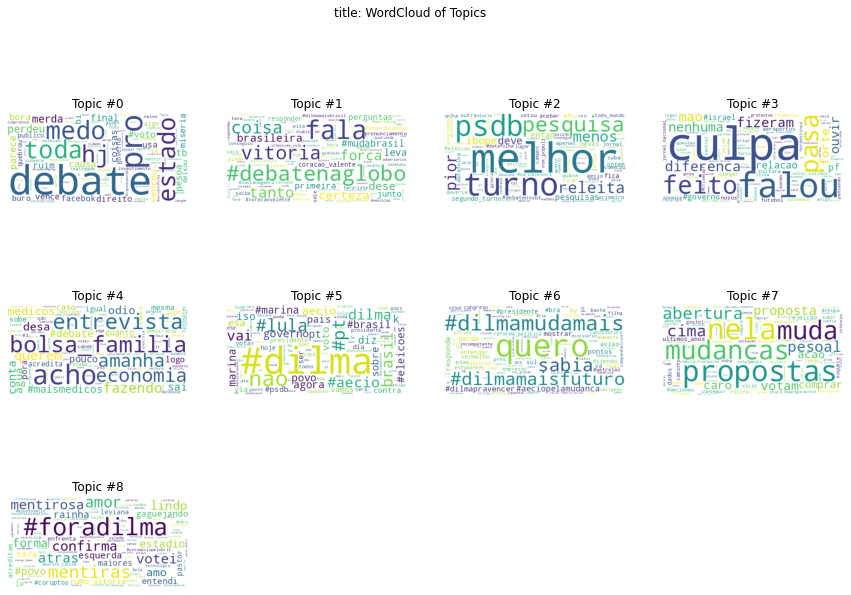

In [12]:
display_wordcloud('title: WordCloud of Topics ',9)


# Topic scores and Charts

In [13]:
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

In [14]:
dominant_topics, topic_percentages = topics_per_document(model=lda, corpus=common_corpus, end=-1)            

In [41]:
topic_percentages


[[(0, 0.036828127),
  (1, 0.09749088),
  (2, 0.061494786),
  (3, 0.01897833),
  (4, 0.04613521),
  (5, 0.70191383),
  (6, 0.020402106),
  (7, 0.010236601)],
 [(0, 0.03841359),
  (1, 0.03763035),
  (2, 0.064136066),
  (3, 0.01979643),
  (4, 0.04811927),
  (5, 0.7531464),
  (6, 0.021281578),
  (7, 0.010676827)],
 [(0, 0.032214906),
  (1, 0.031557992),
  (2, 0.07111474),
  (3, 0.01660106),
  (4, 0.14745356),
  (5, 0.6685536),
  (6, 0.017846493)],
 [(0, 0.034041468),
  (1, 0.0333473),
  (2, 0.07579034),
  (3, 0.017542316),
  (4, 0.13720295),
  (5, 0.6677285),
  (6, 0.018858364)],
 [(0, 0.040126584),
  (1, 0.039308418),
  (2, 0.089393236),
  (3, 0.02067926),
  (4, 0.050265),
  (5, 0.71974134),
  (6, 0.02223064),
  (7, 0.011152924)],
 [(0, 0.05405314),
  (1, 0.0339913),
  (2, 0.05793423),
  (3, 0.03723234),
  (4, 0.081935264),
  (5, 0.6998439),
  (6, 0.019223448)],
 [(0, 0.0340632),
  (1, 0.033368595),
  (2, 0.08510482),
  (3, 0.017553544),
  (4, 0.08003718),
  (5, 0.69650346),
  (6, 0.03787

In [15]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

topic_weights = []
for i, row_list in enumerate(lda[common_corpus]):
    topic_weights.append([w for i, w in row_list[0]])

topic_weights

[[0.036828134,
  0.09749077,
  0.061494794,
  0.018978331,
  0.046135217,
  0.70191395,
  0.02040211,
  0.010236603],
 [0.03841359,
  0.03763035,
  0.064136066,
  0.01979643,
  0.04811927,
  0.7531464,
  0.021281578,
  0.010676827],
 [0.03221491,
  0.031557996,
  0.071114734,
  0.016601061,
  0.14745356,
  0.6685536,
  0.017846493],
 [0.034041468,
  0.0333473,
  0.07579034,
  0.017542316,
  0.13720295,
  0.6677285,
  0.018858364],
 [0.040126584,
  0.039308418,
  0.089393236,
  0.02067926,
  0.050265,
  0.71974134,
  0.02223064,
  0.011152924],
 [0.054053143,
  0.0339913,
  0.05793423,
  0.03723234,
  0.081935264,
  0.6998439,
  0.019223448],
 [0.0340632,
  0.033368595,
  0.08510467,
  0.017553544,
  0.08003717,
  0.6965036,
  0.03787064],
 [0.03340606,
  0.032724857,
  0.055830076,
  0.017214878,
  0.15330821,
  0.6738099,
  0.018506357],
 [0.03300204,
  0.032329097,
  0.055104196,
  0.01700695,
  0.041341655,
  0.7879178,
  0.018282833],
 [0.03411541,
  0.033419743,
  0.06454107,
  0.

In [55]:
lda[common_corpus][1000][0]

[(0, 0.07070715),
 (1, 0.032738738),
 (2, 0.0743951),
 (3, 0.017225036),
 (4, 0.060505033),
 (5, 0.7107117),
 (6, 0.018517284)]

In [ ]:
plt.figure(figsize=(30, 12))
ax = sns.lineplot(
             x = "at", y = "score",
             hue = "result_topic",
             palette = sns.color_palette("bright", 8),
             data = df_2020,
             # hue_order = hue_order,
             ci = None
            )
plt.grid()
plt.legend(title='Topicos', loc='upper left')
plt.xticks(df_2020['at'])
ax.set(xlabel='Meses', ylabel='Quantidade')

In [18]:
arr = pd.DataFrame(topic_weights).fillna(0).values
arr = arr[np.amax(arr, axis=1) > 0.35]

In [21]:
# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

/home/dnelub/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 73292 samples in 0.109s...
[t-SNE] Computed neighbors for 73292 samples in 6.677s...
[t-SNE] Computed conditional probabilities for sample 1000 / 73292
[t-SNE] Computed conditional probabilities for sample 2000 / 73292
[t-SNE] Computed conditional probabilities for sample 3000 / 73292
[t-SNE] Computed conditional probabilities for sample 4000 / 73292
[t-SNE] Computed conditional probabilities for sample 5000 / 73292
[t-SNE] Computed conditional probabilities for sample 6000 / 73292
[t-SNE] Computed conditional probabilities for sample 7000 / 73292
[t-SNE] Computed conditional probabilities for sample 8000 / 73292
[t-SNE] Computed conditional probabilities for sample 9000 / 73292
[t-SNE] Computed conditional probabilities for sample 10000 / 73292
[t-SNE] Computed conditional probabilities for sample 11000 / 73292
[t-SNE] Computed conditional probabilities for sample 12000 / 73292
[t-SNE] Computed conditional probabilities for sam

/home/dnelub/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 85.093895
[t-SNE] KL divergence after 1000 iterations: 1.753796


In [30]:
from matplotlib import colors as mcolors
# Plot the Topic Clusters using Bokeh
topic_num = np.argmax(arr, axis=1)
output_notebook()
n_topics = 9
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

Loading BokehJS ...

In [26]:
topic_num

array([5, 5, 5, ..., 5, 5, 5])